In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.optimize import curve_fit

import dynesty

sns.set(font="Serif",font_scale=1.2)

In [66]:
rv_data = pd.read_csv('Data/lmc-obs45578-835_fxcor_results.dat',delimiter="\s+")

In [67]:
rv_data

,hjd_ref,hjd_obs,hjd_diff,spec_line,vrel,verr,tdr
0,2.458837e+06,2.458837e+06,0.00000,HeII_5411,-0.0002,0.000,5.842E7
1,2.458837e+06,2.458837e+06,0.00000,HeII_4686,-0.0001,0.000,5.988E7
2,2.458837e+06,2.458837e+06,0.00000,HeII_4542,-0.0002,0.000,6.050E7
3,2.458837e+06,2.458837e+06,0.00000,HeII_4201,-0.0002,0.000,5.616E7
4,2.458837e+06,2.458837e+06,0.00000,HeII_4026,-0.0001,0.000,5.067E7
...,...,...,...,...,...,...,...
80,2.458837e+06,2.458867e+06,29.99187,HeIIH_blend,INDEF,INDEF,INDEF
81,2.458837e+06,2.458867e+06,29.99187,HeIIH_blend_lite,-47.1257,7.380,78.44
82,2.458837e+06,2.458867e+06,29.99187,All_lines,-78.0090,22.978,59.89
83,2.458837e+06,2.458867e+06,29.99187,All_lines_lite,-46.9038,6.905,80.56


In [68]:
np.unique(rv_data['spec_line'])

array(['All_lines', 'All_lines_lite', 'Full', 'HeII3835/Hg',
       'HeII3889/Hf', 'HeII3969/He', 'HeII4101/Hd', 'HeII4339/Hc',
       'HeII4860/Hb', 'HeIIH_blend', 'HeIIH_blend_lite', 'HeII_4026',
       'HeII_4201', 'HeII_4542', 'HeII_4686', 'HeII_5411', 'HeII_iso'],
      dtype=object)

In [69]:
class fit_spec:
    
    
    def __init__(self,spec_line_string):
    
        # Pick Line
        line = rv_data[rv_data['spec_line'] == spec_line_string]
        
        # Drop If 'INDEF'
        line = line[line['verr'] != 'INDEF']

        # Drop If 0 Error
        line = line[line['verr'].astype(float) != 0]
        
        # Rest Index
        line = line.reset_index(drop=True)
        
        # Get Data
        self.mjd = np.array([float(l) for l in line['hjd_obs']])
        self.mjd = self.mjd - np.min(self.mjd) + 1
        self.vrel = np.array([float(l) for l in line['vrel']])
        self.verr = np.array([float(l) for l in line['verr']])

        # Fit Line
        #popt, pcov = curve_fit(self.f, self.mjd,self.vrel)

        # Get range of mjds to fit over
        self.date_range = np.linspace(np.min(self.mjd)-1,np.max(self.mjd)+1,400)

        # Get Curve
        #self.vel = self.f(self.date_range,popt[0],popt[1],popt[2])
        
    
    # Curve to fit to
    def f(self,x,a,b,c):
        return a * np.sin(b * x) + c
    

<ErrorbarContainer object of 3 artists>

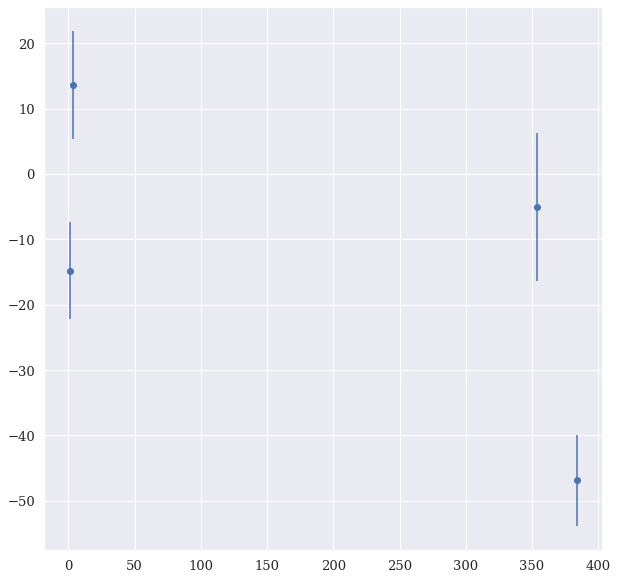

In [72]:
HeII_iso = fit_spec('All_lines_lite')

# plot results
plt.figure(figsize=(10,10))

# data
plt.errorbar(HeII_iso.mjd, HeII_iso.vrel, yerr=HeII_iso.verr,
             ls="none", marker="o")

In [73]:
def func(theta, x=HeII_iso.mjd):
    """
    Fit a sine wave with some amplitude `a`, 
    period `b`, phase `c`, and offset `d`.
    
    """
    
    a, b, c, d = theta
    
    return a * np.sin(2. * np.pi * x / b + c) + d

def loglike(theta):
    """
    Compute the log-likelihood from the predicted model.
    Assumes the data have Gaussian uncertainties.
    
    """
    
    
    pred = func(theta)
    
    chi2 = (HeII_iso.vrel - pred)**2 / HeII_iso.verr**2
    lnorm = np.log(2. * np.pi * HeII_iso.verr**2)
    
    lnl = -0.5 * np.sum(chi2 + lnorm)
    
    return lnl

def prior_transform(u):
    """
    Implementation of priors for nested sampling via the
    'prior transform'. Priors are assumed to be uniform
    over all parameters.
    
    """
    
    x = np.copy(u)
    x[0] = u[0] * 1000
    x[1] = u[1] * 5.5 + 0.5
    x[2] = u[2] * 2. * np.pi
    x[3] = u[3] * 400. - 200.
    
    return x

In [77]:
sampler = dynesty.NestedSampler(loglike, prior_transform, 4, periodic=[2], 
                                bound='single', sample='rwalk', walks=50, nlive=2000)

In [78]:
sampler.run_nested(dlogz=0.01)

7832it [00:06, 197.80it/s, bound: 2 | nc: 50 | ncall: 99844 | eff(%):  7.844 | loglstar:   -inf < -107.529 <    inf | logz: -115.827 +/-  0.086 | dlogz: 98.980 >  0.010]   C:\Users\joshspeagle\Anaconda3\lib\site-packages\dynesty\sampling.py:238: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
C:\Users\joshspeagle\Anaconda3\lib\site-packages\dynesty\sampling.py:216: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
32532it [01:57, 276.77it/s, +2000 | bound: 89 | nc: 1 | ncall: 1426671 | eff(%):  2.420 | loglstar:   -inf < -12.249 <    inf | logz: -23.901 +/-  0.099 | dlogz:  0.000 >  0.010]


In [45]:
#sampler.add_final_live()

iter: 69091 | +3000 | bound: 139 | nc: 1 | ncall: 5471915 | eff(%):  1.317 | loglstar:   -inf < -8.763 <    inf | logz: -20.541 +/-  0.064 | dlogz:  0.065 >  0.010                                   IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [79]:
res = sampler.results

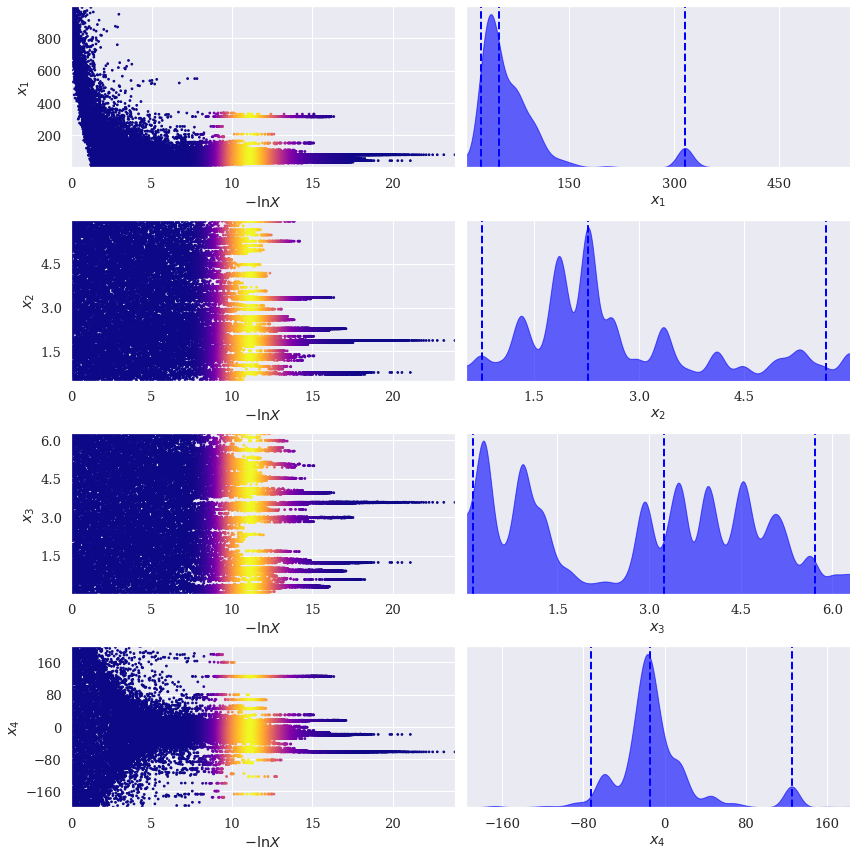

In [80]:
from dynesty import plotting as dyplot

dyplot.traceplot(res)
plt.tight_layout()

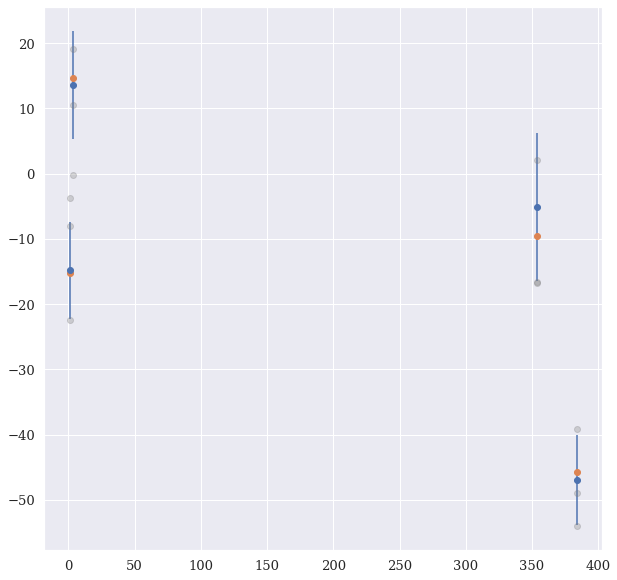

In [99]:
# plot results
plt.figure(figsize=(10,10))

# data
plt.errorbar(HeII_iso.mjd, HeII_iso.vrel, yerr=HeII_iso.verr,
             ls="none", marker="o")

# maixmum-likelihood fit
plt.plot(HeII_iso.mjd, func(res.samples[-1], x=HeII_iso.mjd), marker='o', linestyle='none')

# random samples
for s in res.samples[np.random.choice(len(res.samples), size=3, 
                                      p=np.exp(res.logwt)/np.sum(np.exp(res.logwt)))]:
    plt.plot(HeII_iso.mjd, func(s, x=HeII_iso.mjd), alpha=0.3, color='gray', marker='o', linestyle='none')

(<Figure size 1152x1152 with 4 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000265089B70C8>,
       dtype=object))

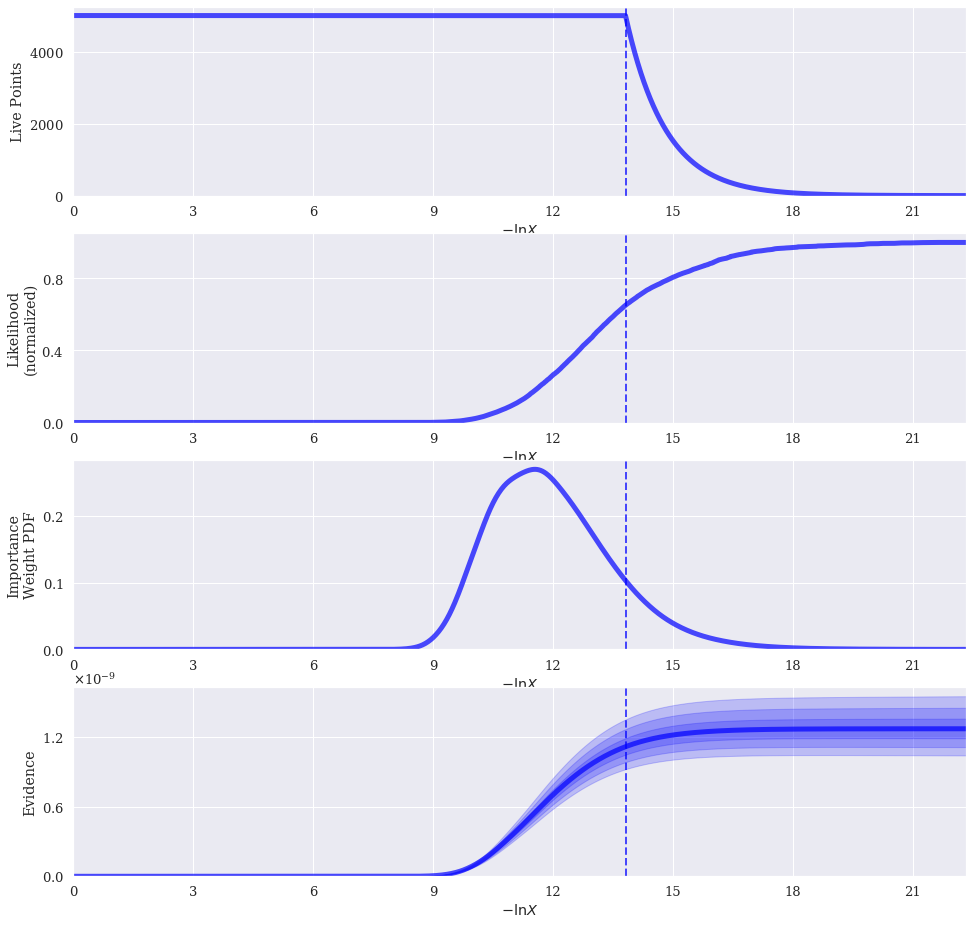

In [63]:
dyplot.runplot(res)

AttributeError: 'fit_spec' object has no attribute 'date_range'

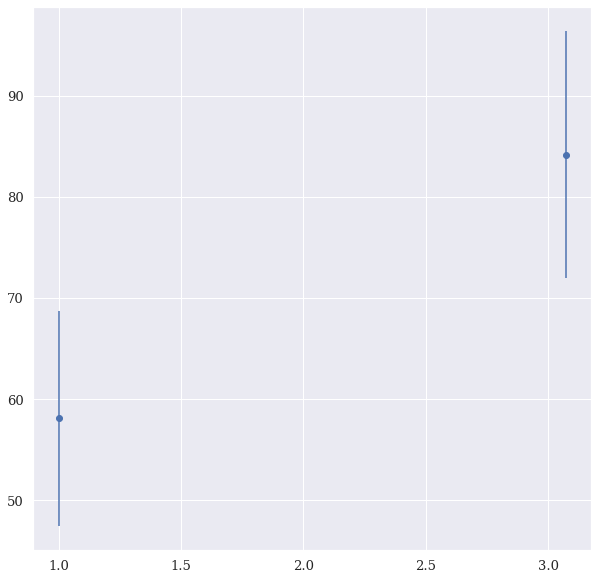

In [14]:
HeII_iso = fit_spec('HeIIH_blend')

plt.figure(figsize=(10,10))
plt.errorbar(HeII_iso.mjd,HeII_iso.vrel,yerr = HeII_iso.verr,ls="none",marker="o")
plt.plot(HeII_iso.date_range,HeII_iso.vel)


/home/bethany/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


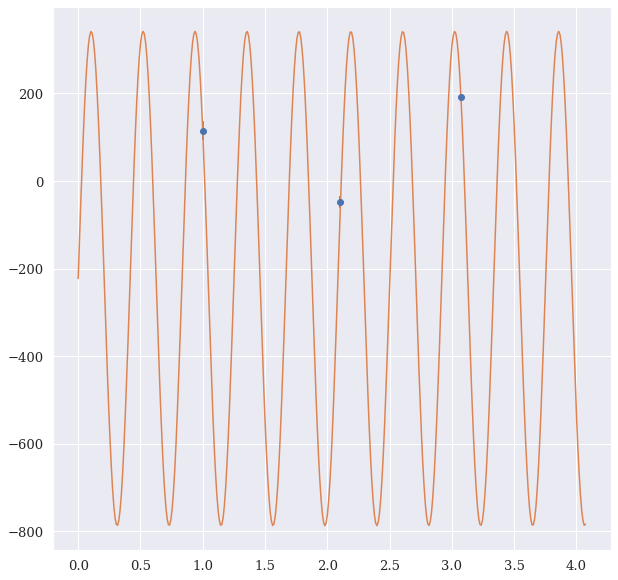

In [7]:
HeII_iso = fit_spec('HeII_iso')

plt.figure(figsize=(10,10))
plt.errorbar(HeII_iso.mjd,HeII_iso.vrel,yerr = HeII_iso.verr,ls="none",marker="o")
plt.plot(HeII_iso.date_range,HeII_iso.vel)

In [8]:
HeII_iso = fit_spec('HeII_4026')

plt.figure(figsize=(10,10))
plt.errorbar(HeII_iso.mjd,HeII_iso.vrel,yerr = HeII_iso.verr,ls="none",marker="o")
plt.plot(HeII_iso.date_range,HeII_iso.vel)

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.